### Prerequisits

This notebook uses the provided test data of the _Sentinel 6a_ satellite for observations between 01/01/2020 and 12/31/2024 which has no gaps in its observations. We will come back how to handle this problem at another time. 

Before running the notebook, one has to extract the contents of `../sat/s6assa2024/s6assa_20_24.csv.zip` to be able to work with the corresponding .csv-file. 

### Imports

We start with importing all necessary libraries, setting the current working directory and defining the relevant physical constant such as the _mass of the earth_ $M_{earth}$, Newton's _gravitational constant_ $G$ and the _standard gravitational parameter_ $\mu \approx G \cdot M_{earth}$ (wher in the approximation we omit the mass of the satellite since $M_{earth} + M_{sat}\approx M_{earth}$) 

In [1]:
# PROCESSING DATA IMPORTS
import numpy as np
import pandas as pd

from datetime import timedelta
import scipy.constants
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler

import pmdarima as pm
import statsmodels.tsa.stattools as sts
import statsmodels.graphics.tsaplots as sgt
from statsmodels.tsa.seasonal import seasonal_decompose

from scipy.ndimage import gaussian_filter1d
from scipy.ndimage import convolve1d
from scipy.optimize import curve_fit

# SYSTEM 
import os
import sys
from pathlib import Path

# SPECIFY WORKING DIRECTORY (LOCATION OF SATELLITE .csv FILES)
cwd = Path(os.getcwd())

# VISUALISATION
import matplotlib.pyplot as plt
# %matplotlib inline

# IMPORT UTILITY FUNCIONS
sys.path.append(str(cwd.parent)+'/src/') # append path to ./src/ for following imports
import preprocessing_utils as preputls



# CONSTANTS 
M_earth = 5.972E24 # earth mass [kg]
G = scipy.constants.G # grav constant [m^3 s^{-2} kg^{-1}]
mu = G*M_earth # standard grav parameter for m (mass moving object) << M_earth [m^3 s^{-2}]  

print('imports complete.')

imports complete.


### Loading and Preprocessing Data

The script _download_DORIS_data.py_ downloads the data for a chosen satellite in a chosen time frame and for chosen control centers (which have computed the state vector from the raw observational data) and returns a single .csv-file. 

After the .csv-file is loaded, it contains duplicated time indices because the data is seperated into several .Z-files (to make downloads feasible) with overlapping starting and ending times of the observations. These indices have to be dropped.

The original data is provided in a _SP3 format_ which records positions in **km** and velocities in **dm/s**. 
To be conform with the phyisical constant we have defined, we convert these units into **m** and **m/s**.

In addition, we directly compute a set of orbital elements, chosen from the table below.

|**classical** | **mean** | **modified equinoctial**|
|--------------|----------|-------------------------|
| $a$ (semi-major axis) | $E$ (eccentric anomaly) | $p$ (semi-parameter)|
| $e$ (eccentricity ) | $M$ (mean anomaly) | $f = e \cos(\omega + \Omega)$ |
| $i$ (Inclination) | $n$ (mean angular motion) | $g = e \sin(\omega + \Omega)$ |
| $\nu$ (true anomaly) | | $q_1 = \tan(i/2)\cos(\Omega)$ |
| $\omega$ (argument of perigee)| | $q_2 = \tan(i/2)\sin(\Omega)$|
| $\Omega$ (RAAN) | | $L = \Omega + \omega + \nu$ (true longitude)|

For the sake of readibility of the code, we create a single pipeline to load and preprocess the data (as above) using `sklearn.pipeline.Pipeline` class.

**Remark:**

The transformer `OrbitalElements` takes an optional parameter `type` which can be set to either of the following strings: `'kepler', 'equinoctial', 'all','custom'`. The option `type='kepler'` computes the classical keplerian elements;  `type='equinoctial'` computes the modified equinoctial elements and  `type='all'` computes all elements in the table above. If `type` is set to `'custom'`, one has to pass an additional optional parameter `custom_elements` (by default set to `None`) which takes a list of elements want to compute, for example `custom_elements=['i','E','p']`.



In [2]:
# LOADING AND PREPROCESSING SATELLITE DATA

sat_path = str(cwd.parent)+'/sat/s6assa2024/s6assa_20_24.csv'

if not os.path.isfile(sat_path):
    raise Exception('Indicated path does not point to a valid file')

# DEFINE CUSTOM TRANSFORMERS
load_sat = preputls.LoadSingleSat(path=sat_path)
drop_dupl_idx = preputls.DropDuplIdx()
convert_units = preputls.ConvertUnits()
compute_orbital_elements = preputls.OrbitalElements(type='all')

# BUILD PIPELINE FOR PREPROCESSING
prep_pipeline = Pipeline(
    steps=[
    ('load_sat', load_sat),                                 # load satellite data
    ('drop_duplicated_idx', drop_dupl_idx),                 # drop duplicated indices
    ('convert_units',convert_units),                        # convert units 
    ('compute_orbital_elements',compute_orbital_elements)   # compute orbital elements
])

print('Loading data ... ',end='')
# GET DATA FROM PIPELINE
s6ssa = prep_pipeline.fit_transform(None)

print('done.\n')

# CHECK FOR NAN
print('Checking for null-values:')
print(s6ssa.isna().sum().value_counts())

print('\n loading of satellite data complete.')

Loading data ... done.

Checking for null-values:
0    21
Name: count, dtype: int64

 loading of satellite data complete.


In [3]:
s6ssa.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1929376 entries, 2020-11-26 08:59:00 to 2024-07-28 05:14:00
Data columns (total 21 columns):
 #   Column  Dtype  
---  ------  -----  
 0   x       float64
 1   y       float64
 2   z       float64
 3   vx      float64
 4   vy      float64
 5   vz      float64
 6   a       float64
 7   e       float64
 8   i       float64
 9   nu      float64
 10  omega   float64
 11  Omega   float64
 12  p       float64
 13  f       float64
 14  g       float64
 15  q1      float64
 16  q2      float64
 17  L       float64
 18  E       float64
 19  M       float64
 20  n       float64
dtypes: float64(21)
memory usage: 323.8 MB


For the analysis it is important to have no gaps in the observations. We hence look at the time differences between the observations

In [4]:
# CHECK TIME DIFFERENCES OF OBSERVATIONS

s6ssa.index.diff().value_counts()

time_stamp
0 days 00:01:00    1929375
Name: count, dtype: int64

Next, we load the scheduled manoeuvres obtained from the _download_maneuver_schedule.py_ script and filter the data for the manoeuvres scheduled for _Sentinel 6a_ between 01/01/2020 and 12/31/2024.

In [5]:
# LOADING LIST OF PRE-SCHEDULED MANEUVERS
path_ref = str(cwd.parent)+'/ref/'

print('Loading manoeuvres ... ',end='')

if os.path.isdir(path_ref):
    path_list_man = path_ref + '/manoeuvres_schedule.csv'
    if os.path.isfile(path_list_man):
           manoeuvres = pd.read_csv(path_list_man,index_col=0)
    else: 
        raise Exception(f'No file named maneuvers_schedule.csv found.')
else:
    raise Exception(f'No directory named {path_ref} found.')
   
manoeuvres.start = pd.to_datetime(manoeuvres.start)
manoeuvres.end = pd.to_datetime(manoeuvres.end)

mans6a2024 = manoeuvres[(manoeuvres.sat_id == 's6a') & (manoeuvres.start.dt.year.isin(range(2020,2025)))].drop(['sat_id','end'],axis=1).set_index('start').sort_index()

print('done.')

Loading manoeuvres ... done.


### Explorative Analysis

We start by looking at some orbital elements around a manoeuvre (which we take from the list of scheduled manoeuvres we loaded in the last step).

In [6]:
mans6a2024.reset_index().T

,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
start,2020-11-23 02:38:00,2020-11-23 09:50:00,2020-11-24 01:38:00,2020-11-27 05:22:00,2020-12-10 05:01:00,2020-12-14 05:15:00,2020-12-16 06:27:00,2020-12-18 00:38:00,2021-02-18 01:45:00,2021-04-27 07:42:00,...,2022-03-08 03:00:00,2022-06-22 07:30:00,2022-10-13 06:50:00,2022-12-05 10:35:00,2023-01-17 13:15:00,2023-05-25 06:05:00,2023-08-03 07:02:00,2023-11-29 08:25:00,2024-02-29 09:17:00,2024-05-28 09:51:00


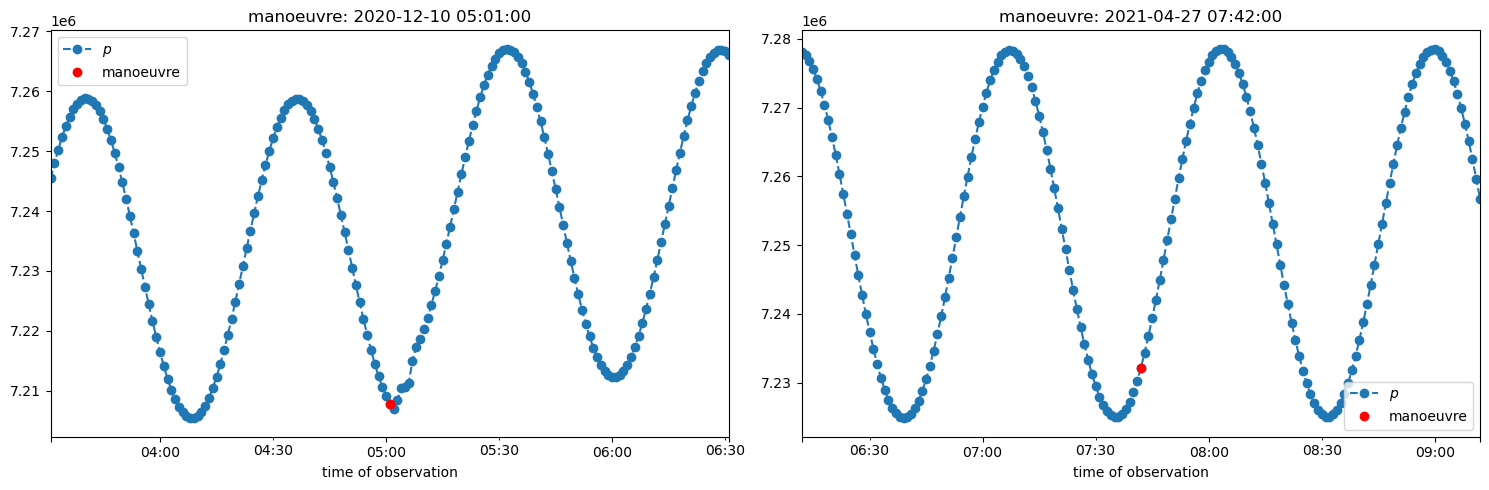

In [7]:
dt = timedelta(hours=1.5)

# DATE OF MANOEUVRE
man_date_1 = mans6a2024.reset_index()['start'].iloc[4]
man_date_2 = mans6a2024.reset_index()['start'].iloc[9]

# VALUE OF OBSERVABLE (p) AT TIME OF MANOEUVRE
man_location_1 = pd.Series(s6ssa['p'].loc[man_date_1],index=[man_date_1])
man_location_2 = pd.Series(s6ssa['p'].loc[man_date_2],index=[man_date_2])

fig, ax = plt.subplots(ncols=2,nrows=1,figsize=(15,5))

s6ssa['p'].loc[man_date_1 - dt:man_date_1 + dt].plot(xlabel='time of observation',style='o--',title=f'manoeuvre: {str(man_date_1)}',ax=ax[0],label=r'$p$',legend=True)
man_location_1.plot(ax=ax[0],style=['ro'],label = 'manoeuvre',legend=True)

s6ssa['p'].loc[man_date_2 - dt:man_date_2 + dt].plot(xlabel='time of observation',style='o--',title=f'manoeuvre: {str(man_date_2)}',ax=ax[1],label=r'$p$',legend=True)
man_location_2.plot(ax=ax[1],style=['ro'],label = 'manoeuvre',legend=True)

plt.tight_layout()
plt.show()

We make the following observations:

1. The orbital element $p$ follows a sinusoidal pattern (caution: this is _not_ true for all orbital elements)

2. At the time a manoeuvre is initiated, the time series diverges from its pattern.

In order to amplify this divergence form the "normal behaviour", we consider the first and second derivatives

In [8]:
def grad(ts:pd.Series)->pd.Series:
    ts_ = ts.copy()
    dt = (ts_.index - ts_.index[0]).total_seconds()
    tsname_ = ts_.name
    tsdot_ = pd.Series(np.gradient(ts_,dt),ts.index,name='dot_{c}'.format(c=tsname_))

    return tsdot_

In [9]:
# pdot AT THE TIME OF A MANOEUVRE 

dot_p = grad(s6ssa['p'])
ddot_p = grad(dot_p)

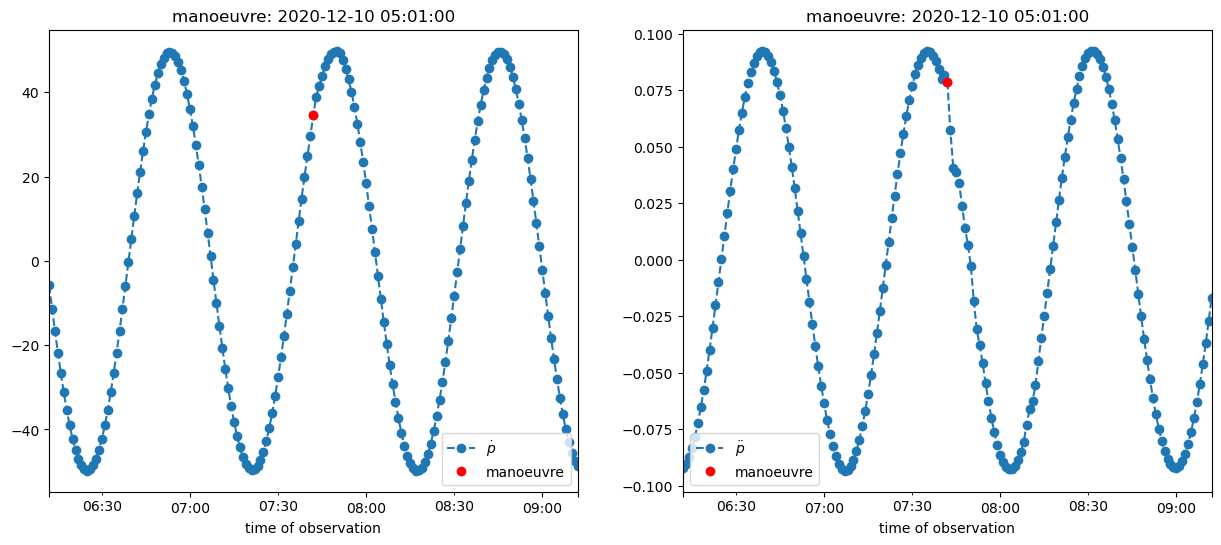

In [10]:
# DATE OF MANOEUVRE 
man_date_2 = mans6a2024.reset_index()['start'].iloc[9]

# VALUE OF dot_p AND ddot_p AT TIME OF MANOEUVRE 
man_location_dot_p_2 = pd.Series(dot_p.loc[man_date_2],index=[man_date_2])
man_location_ddot_p_2 = pd.Series(ddot_p.loc[man_date_2],index=[man_date_2])


# PLOT dot_p, ddot_p
fig, ax = plt.subplots(ncols=2,nrows=1,figsize=(15,6))
dot_p.loc[man_date_2 - dt:man_date_2 + dt].plot(ax=ax[0],xlabel='time of observation',style='o--',title=f'manoeuvre: {str(man_date_1)}',label=r'$\dot p$',legend=True)
man_location_dot_p_2.plot(ax=ax[0],style=['ro'],label = 'manoeuvre',legend=True)

ddot_p.loc[man_date_2 - dt:man_date_2 + dt].plot(ax=ax[1],xlabel='time of observation',style='o--',title=f'manoeuvre: {str(man_date_1)}',label=r'$\ddot p$',legend=True)
man_location_ddot_p_2.plot(ax=ax[1],style=['ro'],label = 'manoeuvre',legend=True)
plt.show()

Clearly, the feature (here $p$) shows a temporal pattern.
In order to find the manoeuvre, we would like to extract this pattern and analyse the trend and residuals. 

For example, we start with a standard time series analysis, testing the feature for stationarity and fitting a simple ARIMA model, for which we use the library ``pmdarima``


In [11]:
# STATIONARITY: ADF (AUGMENTED DICKEY-FULLER) TEST 
adf_test = pm.arima.ADFTest(alpha=0.05)


# SINCE THE TIME SERIES HAS A LOT OF DATA POINTS, TEST FOR STATIONARITY IN SPECIFIED INTERVALS [start:end]
start = 100_000
end = 200_000

print('Test of stationarity of dot_p$:')
p_val, should_diff = adf_test.should_diff(dot_p[start:end])
print(f'p value = {p_val}')
print(f'stationary: {~should_diff}\n')

print('Test of stationarity of ddot_p$:')
p_val, should_diff = adf_test.should_diff(ddot_p[start:end])
print(f'p value = {p_val}')
print(f'stationary: {~should_diff}')

Test of stationarity of dot_p$:
p value = 0.01
stationary: True

Test of stationarity of ddot_p$:
p value = 0.01
stationary: True


Next, we look at the autocorrelation (ACF) and partial autocorrelation plots (PCF)

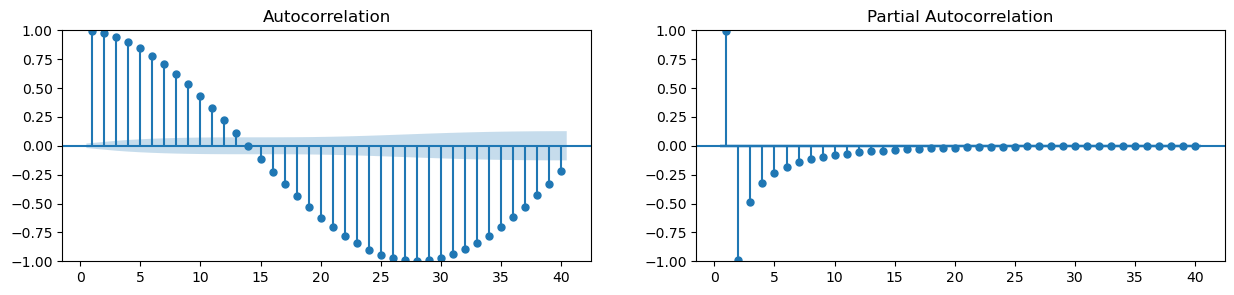

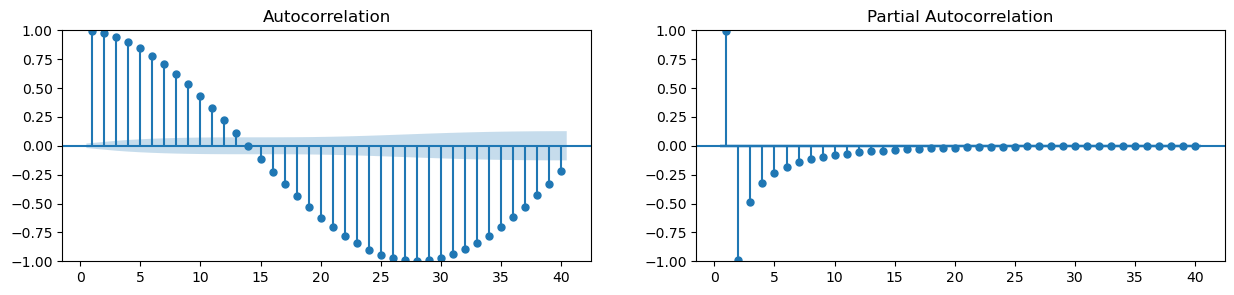

In [172]:
fig, ax = plt.subplots(ncols=2,nrows=1,figsize=(15,3))

sgt.plot_acf(dot_p[:10_000],lags=40,zero=False,ax=ax[0])
sgt.plot_pacf(dot_p[:10_000],lags=40,zero=False,ax=ax[1])

We can see a clear dependency of observations at a fixed time and its prior correlations. Since the features ``dot_p`` and ``ddot_p`` are sationary, we will first have a look at their decomposition into trend, seasonality and residuals. 

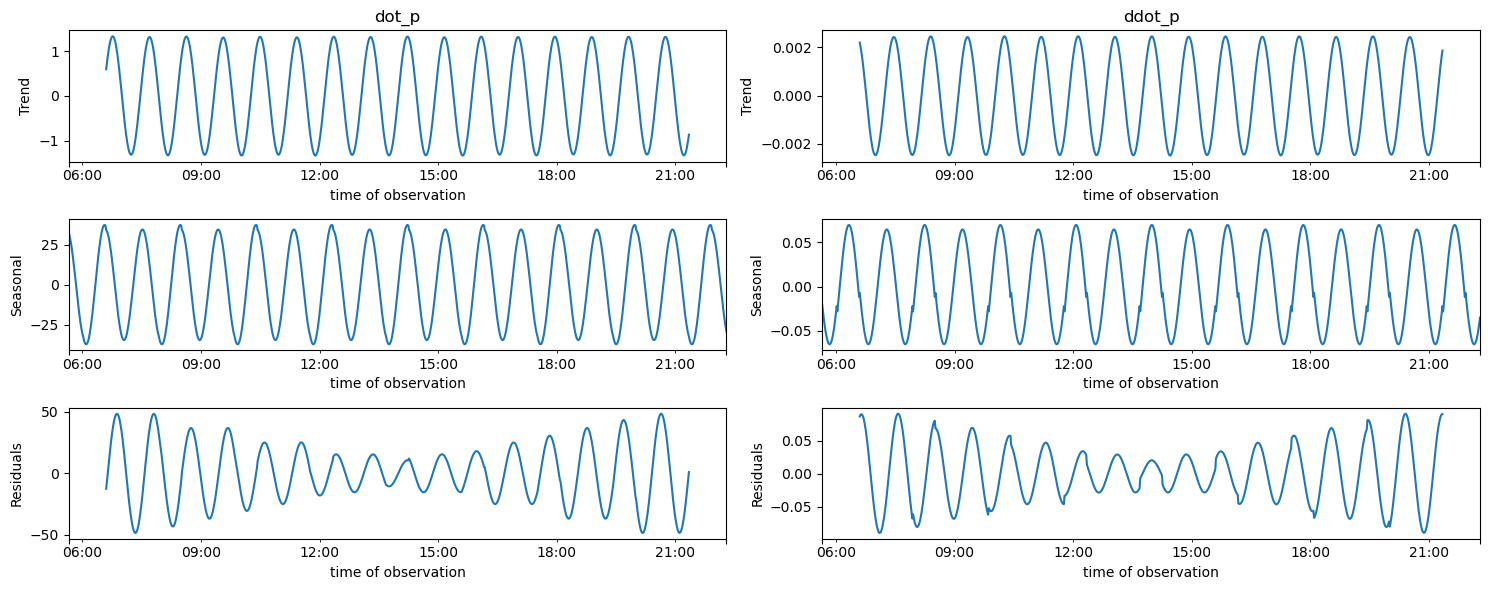

In [13]:
start = 7000
end = 8000

dot_p_decomposed = seasonal_decompose(dot_p[start:end],model='additive',period=115)
ddot_p_decomposed = seasonal_decompose(ddot_p[start:end],model='additive',period=115)


fig, ax = plt.subplots(ncols=2,nrows=3,figsize=(15,6))

dot_p_decomposed.trend.plot(ax=ax[0,0],xlabel='time of observation',ylabel='Trend',title='dot_p')
dot_p_decomposed.seasonal.plot(ax=ax[1,0],xlabel='time of observation',ylabel='Seasonal')
dot_p_decomposed.resid.plot(ax=ax[2,0],xlabel='time of observation',ylabel='Residuals')

ddot_p_decomposed.trend.plot(ax=ax[0,1],xlabel='time of observation',ylabel='Trend',title='ddot_p')
ddot_p_decomposed.seasonal.plot(ax=ax[1,1],xlabel='time of observation',ylabel='Seasonal')
ddot_p_decomposed.resid.plot(ax=ax[2,1],xlabel='time of observation',ylabel='Residuals')

plt.tight_layout()
plt.show()

The most important observation that we make here is that the residuals of the decomposition in trend and seasonality show themselves a repeating temporal pattern. This suggests that not all of the seasonal components have been found in the data. 

A look at the histograms of the residuals shows that they are in fact not following a Gaussian normal distribution and thus cannot be taken as white noise.

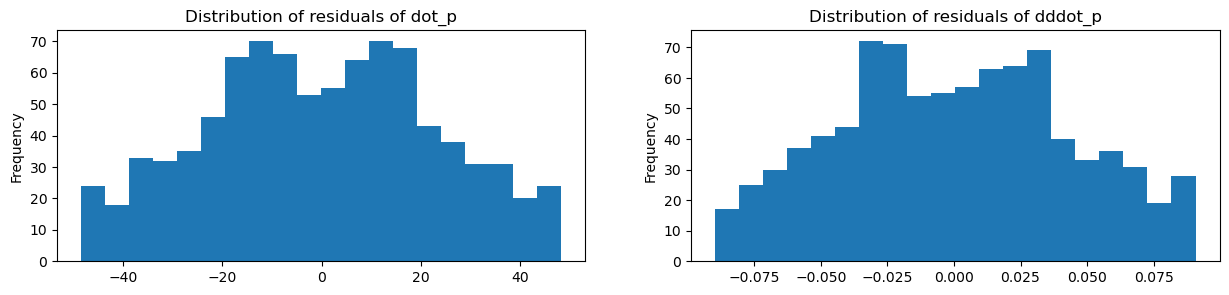

In [173]:
fig, ax = plt.subplots(ncols=2,nrows=1,figsize=(15,3))

dot_p_decomposed.resid.plot.hist(bins=20,ax=ax[0],title='Distribution of residuals of dot_p')
ddot_p_decomposed.resid.plot.hist(bins=20,ax=ax[1],title='Distribution of residuals of dddot_p')

plt.show()

In order to find a better way to extract the seasonality of the time series, we will try to fit a baseline curve to the data. It seems reasonable to start with an AutoARIMA model. Since we are interested in the manoeuvres, we will start with a (small) time window around a manoeuvre.

Due to the sinusoidal nature of the temporal pattern, we will use several harmonics as exogeneous parameters. Moreover, since we are interested simply in detecting the manoeuvre, we will first normalise the values of the feature so that they take values in the intervall [-1,1] mimicing a simple sine-curve.

In [175]:
# DATE OF MANOEUVRE 
man_date_2 = mans6a2024.reset_index()['start'].iloc[4]

# FEATURE
feature = dot_p.loc[man_date_2 - dt:man_date_2 + dt]

# NORMALISE FEATURE
scaler = MinMaxScaler(feature_range=(-1,1))

feature_normalised = pd.Series(
    scaler.fit_transform(feature.values.reshape(-1,1)).flatten(),
    index=feature.index,
    name=feature.name
    )

harmonics = pd.DataFrame()

# FREQUENCY
freq = 1/60 

# NUMBER HARMONICS TO INCLUDE
n_harmonics = 3

for k in range(1,n_harmonics+1):
    harmonics[f'sin{k}'] = np.sin(2 * np.pi * k * freq * feature_normalised)
    harmonics[f'cos{k}'] = np.cos(2 * np.pi * k * freq * feature_normalised)

# ATUO ARIMA MODEL
model = pm.auto_arima(
            y=feature_normalised,
            X=harmonics, 
            seasonal=False,
            stepwise=True,
            suppress_warnings=True,
            max_order=None,
            information_criterion='aicc',
            error_action="ignore")

print(model.summary())


                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  241
Model:               SARIMAX(2, 0, 0)   Log Likelihood                2755.514
Date:                Sat, 05 Oct 2024   AIC                          -5493.028
Time:                        10:44:30   BIC                          -5461.664
Sample:                    12-10-2020   HQIC                         -5480.392
                         - 12-10-2020                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sin1          14.3303      0.001    2.1e+04      0.000      14.329      14.332
cos1       -1.665e-06   2.61e-05     -0.064      0.949   -5.29e-05    4.96e-05
sin2          -2.8699      0.001  -4218.298      0.0

Let us now extract the baseline and compare the baseline with the actual observed data points

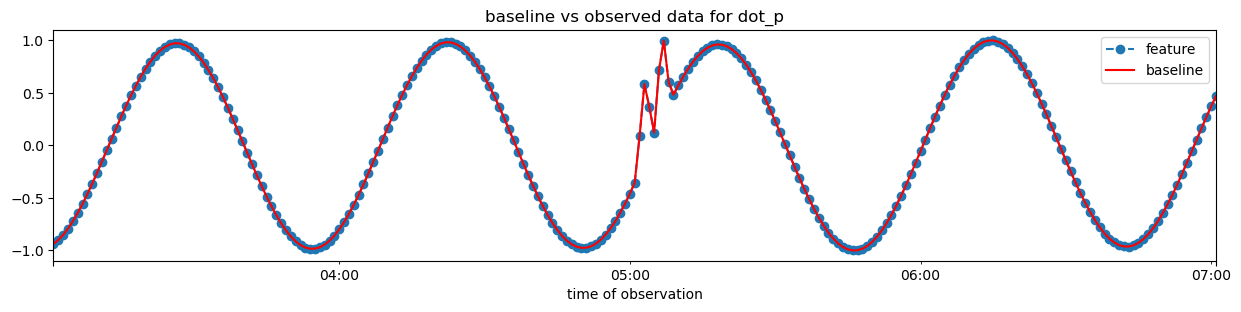

In [176]:
# EXTRACTING BASELINE
baseline = pd.Series(model.predict_in_sample(X=harmonics),index=feature_normalised.index)

# PLOT (NROMALISED) FEATURE AND BASELINE
fig, ax = plt.subplots(figsize=(15,3))

feature_normalised.plot(style='o--',ax=ax,label='feature',legend=True)
baseline.plot(style='r',ax=ax,label='baseline',legend=True)

ax.set_xlabel('time of observation')
plt.title(f'baseline vs observed data for {feature_normalised.name}')
plt.show()

Conclusion: An (Auto) ARIMA model using several harmonics overfits. Hence the model cannot be used to extract the seaosnality (temporal data) of the feautre. 

We thus need to use a simpler model. To this end, we will use a simple harmonic model $y(t) = y_0 + \sum_k \big( s_k \sin(2\pi \nu t) + c_k \cos(2\pi \nu t) \big)$ using ``sklearn.optimize.curve_fit()``.

We will use again the normalised feature as before.

**Remark**: it will be useful to define several convenience functions which compute the baseline and residuals from the harmonic regression and then plots the result.

In [183]:
# HARMONIC MODEL
def harmonics(x,*params):
    """
    Function used in harmonic regression model

    Input:
    x = (predictor) variable
    *params = [offset, freq, scoeffs, ccoeffs]

    where 
    
    - offeset = y0
    - freq = frequency
    - scoeffs = coefficients of sines
    - ccoeffs = coefficients of cosines

    Output:
    y(x) = y_0 + \sum_k \big( s_k \sin(2\pi \nu x) + c_k \cos(2\pi \nu x) \big)

    """
    offset = params[0]
    freq = params[1]
    scoeffs = params[2::2] # COEFFICIENTS OF SIN
    ccoeffs = params[3::2] # COEFFICIENTS OF COS

    res = offset
    for n in range(len(scoeffs)):
        res += scoeffs[n] * np.sin((n+1)*freq*x) + ccoeffs[n] * np.cos((n+1)*freq*x)

    return  res

def harmonic_reg(feature:pd.Series,man_date:str,dt = 2,freq:float = 1/60.,n_harmonics:int = 12):

    # DATE OF MANOEUVRE 
    dt_ = timedelta(hours=dt)
    man_date_ = pd.to_datetime(man_date)

    # FEATURE
    feature_ = feature.loc[man_date_ - dt_ : man_date_ + dt_]

    # NORMALISE FEATURE
    scaler = MinMaxScaler(feature_range=(-1,1))

    feature_normalised_ = pd.Series(
        scaler.fit_transform(feature_.values.reshape(-1,1)).flatten(),
        index=feature_.index,
        name=feature_.name
        )

    # X VALUES = TIME STEPS AT WHICH OBSERVATION HAPPENS 0,1,2,...
    X = np.arange(len(feature_normalised_))

    # FREQUENCY
    freq_ = freq

    n_harmonics_ = n_harmonics

    # GUESS OF INITIAL PARAMETERS
    p0_ = [feature_normalised_.iloc[0],freq_] + list(np.ones(n_harmonics_))

    fit_ = curve_fit(harmonics, xdata=X, ydata=feature_normalised_.values.flatten(),p0=p0_)

    # EXTRACT BASELINE
    baseline_ = pd.Series(harmonics(X,*fit_[0]),name='baseline',index=feature_normalised_.index)

    # COMPUTE RESIDUALS
    residuals_ = feature_normalised_ - baseline_

    return (feature_normalised_, baseline_, residuals_)

def plot_harm_reg(feature:pd.Series,baseline:pd.Series,residuals:pd.Series,man_date:str,plot_resid:bool = True,figszie:tuple[int,int]=(15,4)):

    if plot_resid:
        # PLOT (NROMALISED) FEATURE, BASELINE AND RESIDUALS
        fig, ax = plt.subplots(ncols=2,nrows=1,figsize=figszie)

        feature.plot(style='o--',ax=ax[0],label='feature',legend=True)
        baseline.plot(style='r',ax=ax[0],label='baseline',legend=True)
        ax[0].set_xlabel('time of observation')
        ax[0].set_title(f'SHR for {feature.name}: freq = {freq:.2f}, #harmonics = {n_harmonics}')

        residuals.plot(style='o-',ax=ax[1],title='residuals',label=r'resid')
        ax[1].axhline(y=3*residuals.std(),color='r',label=r'$\pm3\sigma$')
        ax[1].axhline(y=-3*residuals.std(),color='r')
        ax[1].set_xlabel('time of observation')
        ax[1].legend()

        plt.suptitle(f'date of manoeuvre: {man_date}')
        plt.tight_layout()
        plt.show()
    else:
        # PLOT (NROMALISED) FEATURE AND BASELINE
        fig, ax = plt.subplots(figsize=figszie)

        feature.plot(style='o--',ax=ax,label='feature',legend=True)
        baseline.plot(style='r',ax=ax,label='baseline',legend=True)
        ax.set_xlabel('time of observation')
        ax.set_title(f'harmonic regression of {feature_normalised.name} (baseline vs observed) \n date of manoeuvre: {man_date} \nfrequency = {freq:.2f}, number harmonics = {n_harmonics}')
        ax.set_xlabel('time of observation')
    
        plt.show()
   

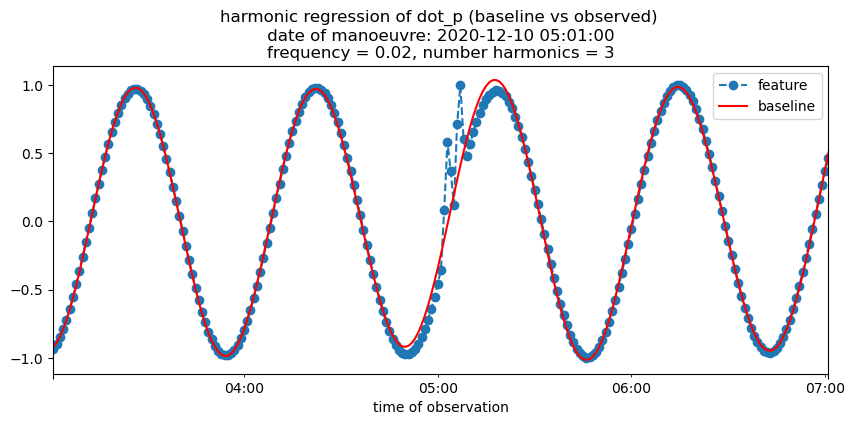

In [185]:
# HARMONIC REGRESSION

# DATE OF MANOEUVRE 
man_date = str(mans6a2024.reset_index()['start'].iloc[4])

feature, baseline, residuals = harmonic_reg(feature=dot_p,man_date=man_date)

plot_harm_reg(feature=feature,baseline=baseline,residuals=residuals,man_date=man_date,plot_resid=False,figszie=(10,4))

The "weaker model" (namely a simple harmonic regression model vs the Auto ARIMA model) clearly does a better job in extracting a baseline curve, since it does not overfit. However we stress that it is very sensitive to the fitting parameters! For example, if we use a different frequency or a smaller number of harmonics can yield drastically different results.

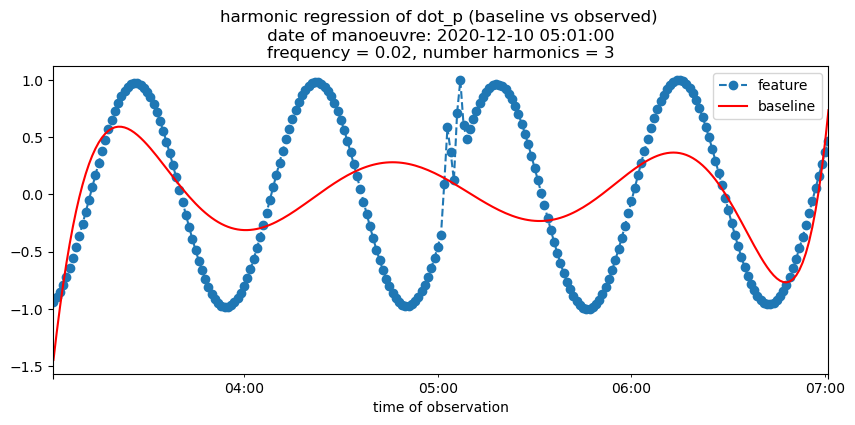

In [186]:
# CHANGING PARAMETERS OF HARMONIC REGRESSION

# DATE OF MANOEUVRE 
man_date = str(mans6a2024.reset_index()['start'].iloc[4])

feature, baseline, residuals = harmonic_reg(feature=dot_p,man_date=man_date,n_harmonics=8,freq=1/60.)

plot_harm_reg(feature=feature,baseline=baseline,residuals=residuals,man_date=man_date,plot_resid=False,figszie=(10,4))

Nevertheless, after fine-tuning, the harmonic regression seems to yield a good baseline curve. Outliers can now be detected by studying the residuals, for example by computing their $z$-score and declaring any residual with $z > 3$ to be an outlier.

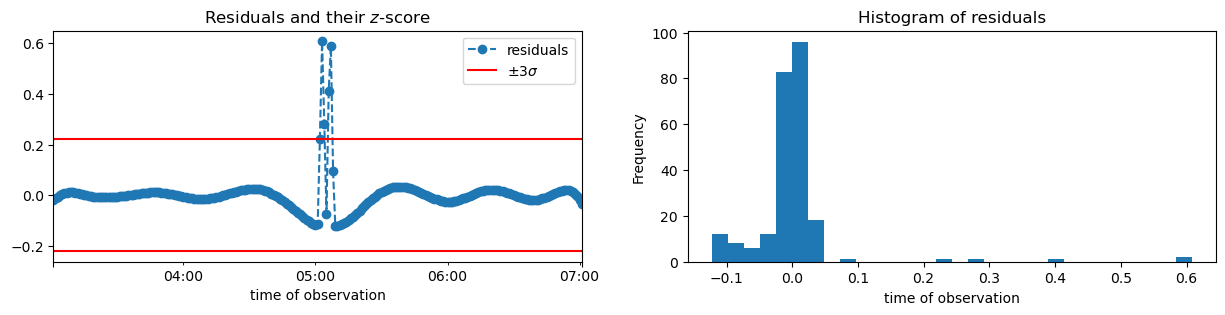

In [188]:
# COMPUTE RESIDUALS
feature, baseline, residuals = harmonic_reg(feature=dot_p,man_date=man_date)


# PLOT RESIDUALS
fig, ax = plt.subplots(ncols=2,nrows=1,figsize=(15,4))

residuals.plot(style='o--',ax=ax[0],label='residuals',legend=True)
ax[0].set_xlabel('time of observation')
ax[0].set_title(r'Residuals and their $z$-score')
ax[0].axhline(y=3*residuals.std(),color='r',label=r'$\pm3\sigma$')
ax[0].axhline(y=-3*residuals.std(),color='r')
ax[0].set_xlabel('time of observation')
ax[0].legend()

residuals.plot.hist(bins=30,ax=ax[1],legend=False)
ax[1].set_xlabel('time of observation')
ax[1].set_title(f'Histogram of residuals')



plt.show()

Note that not all manoeuvres can be detected by the first derivative of the invariant (below we look at the semi-parameter $p$). 
Sometimes it is necessary to also study the second derivative.

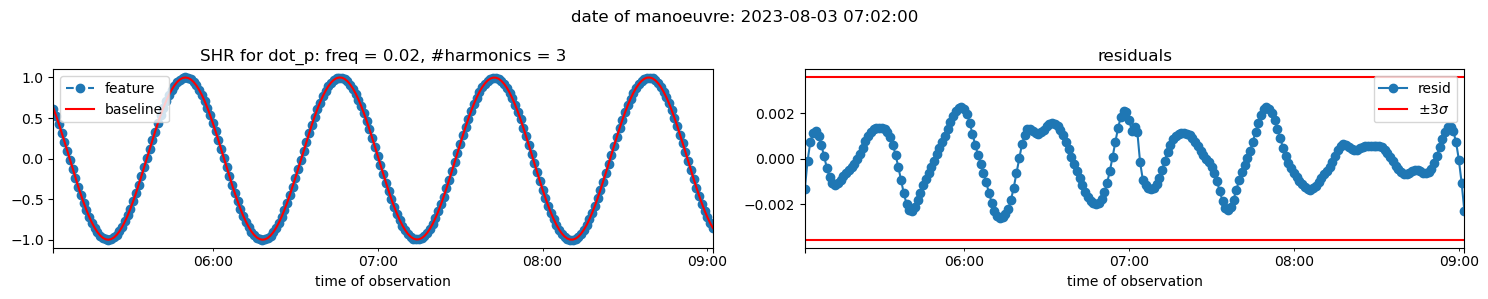

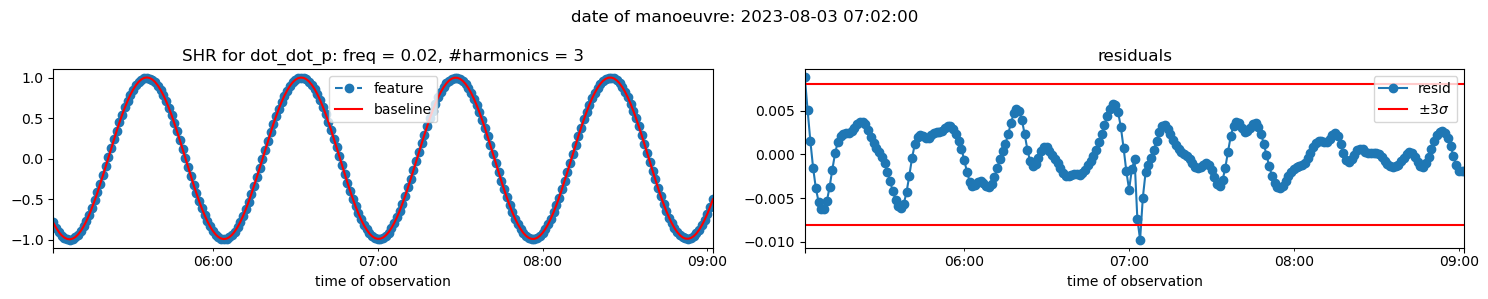

In [189]:
# CHANGE OF DATE OF MANOEUVRE

# DATE OF MANOEUVRE 
man_date = str(mans6a2024.reset_index()['start'].iloc[21])

feature1, baseline1, residuals1 = harmonic_reg(feature=dot_p,man_date=man_date)
feature2, baseline2, residuals2 = harmonic_reg(feature=ddot_p,man_date=man_date)

plot_harm_reg(feature=feature1,baseline=baseline1,residuals=residuals1,man_date=man_date,plot_resid=True,figszie=(15,4))
plot_harm_reg(feature=feature2,baseline=baseline2,residuals=residuals2,man_date=man_date,plot_resid=True,figszie=(15,4))

In fact, some manoeuvres cannot be detected by this method (based on first and second derivative) at all:

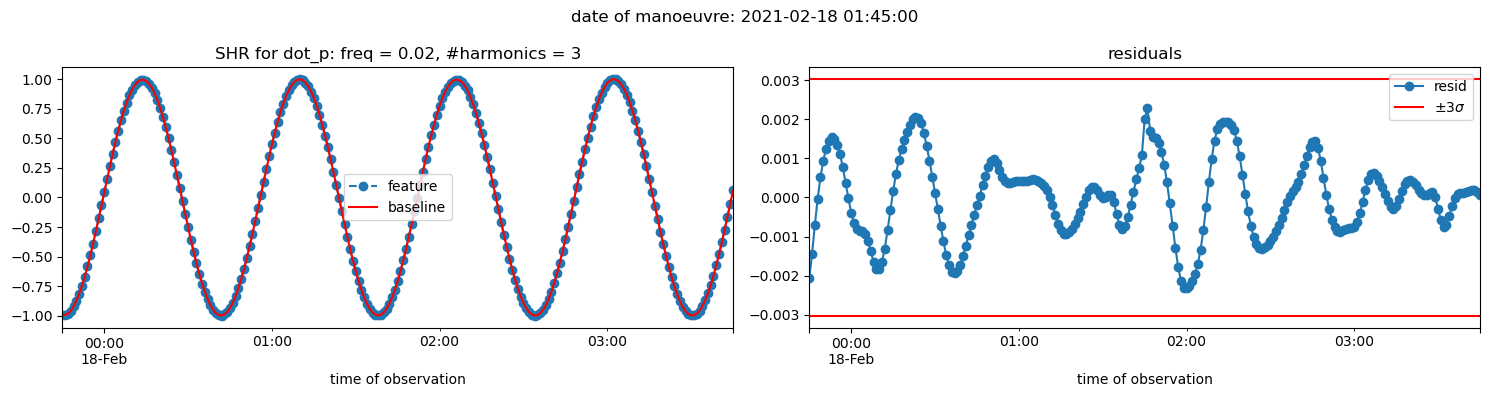

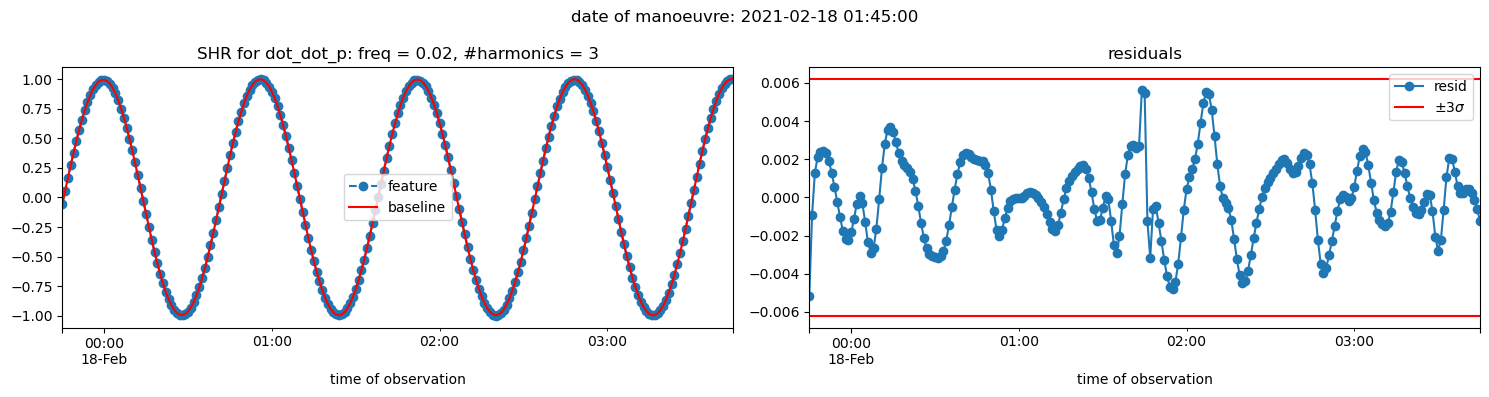

In [191]:
# CHANGE OF DATE OF MANOEUVRE

# DATE OF MANOEUVRE 
man_date = str(mans6a2024.reset_index()['start'].iloc[8])

feature1, baseline1, residuals1 = harmonic_reg(feature=dot_p,man_date=man_date)
feature2, baseline2, residuals2 = harmonic_reg(feature=ddot_p,man_date=man_date)

plot_harm_reg(feature=feature1,baseline=baseline1,residuals=residuals1,man_date=man_date,plot_resid=True,figszie=(15,4))
plot_harm_reg(feature=feature2,baseline=baseline2,residuals=residuals2,man_date=man_date,plot_resid=True,figszie=(15,4))

In addition, sometimes it might happen that the noise is so loud that this simple harmonic regression model produces residuals whose $z$-score is above 3 but which are not associated to a manoeuvre.

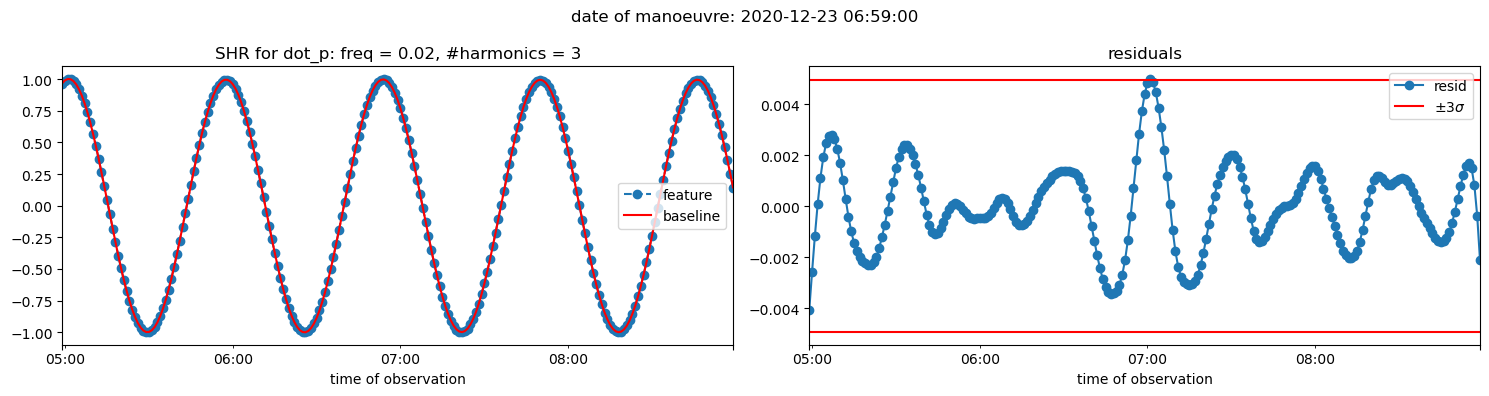

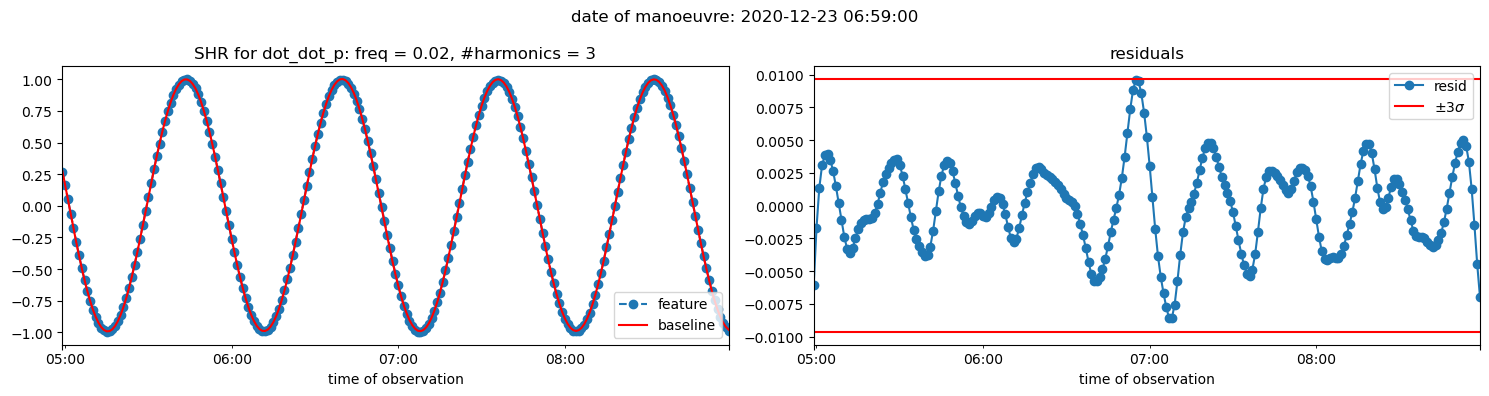

In [192]:
# CHANGE OF DATE OF MANOEUVRE

# DATE OF MANOEUVRE 
man_date = '2020-12-23 06:59:00'

feature1, baseline1, residuals1 = harmonic_reg(feature=dot_p,man_date=man_date)
feature2, baseline2, residuals2 = harmonic_reg(feature=ddot_p,man_date=man_date)

plot_harm_reg(feature=feature1,baseline=baseline1,residuals=residuals1,man_date=man_date,plot_resid=True,figszie=(15,4))
plot_harm_reg(feature=feature2,baseline=baseline2,residuals=residuals2,man_date=man_date,plot_resid=True,figszie=(15,4))

**An important observation**

The above considerations suggest to study the second derivative of our feature (for example of the semi-parameter $p$), as it detects equally well or better the outliers. 
Note however that if in discrete mathematics there are several ways to compute the second derivative, and some methods might perform better than others.
For example, we could compute the second derivative $\ddot f(t)$ of a time series $\dot f(t)$ either by computing consecutively computing the derivative: 
$$ \ddot f(t) = \frac{d}{dt} \Big( \dot f(t) \Big) $$ 
where $$ \dot f(t) \approx \frac{f(t + h) - f(t - h)}{2h} $$
for small timesteps $h$.
Another way would be to compute it directly via 
$$ \ddot f(t) = \frac{f(t + h) - 2f(t) + f(t - h)}{h^2} $$
which can be neatly implemented via a convolution of our time series $f$ with a Laplace filter ``[1,-2,1]``.

Below we compre the methods for _all_ scheduled manoeuvres. The time of the manoeuvre is displayed in red.

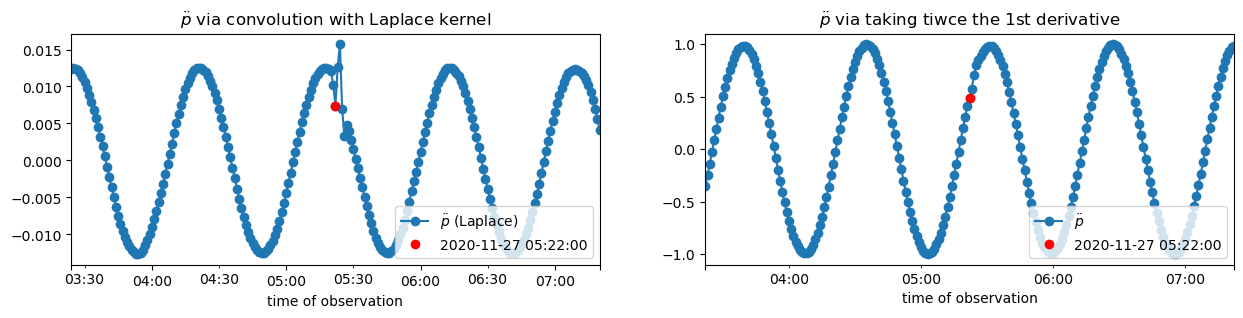

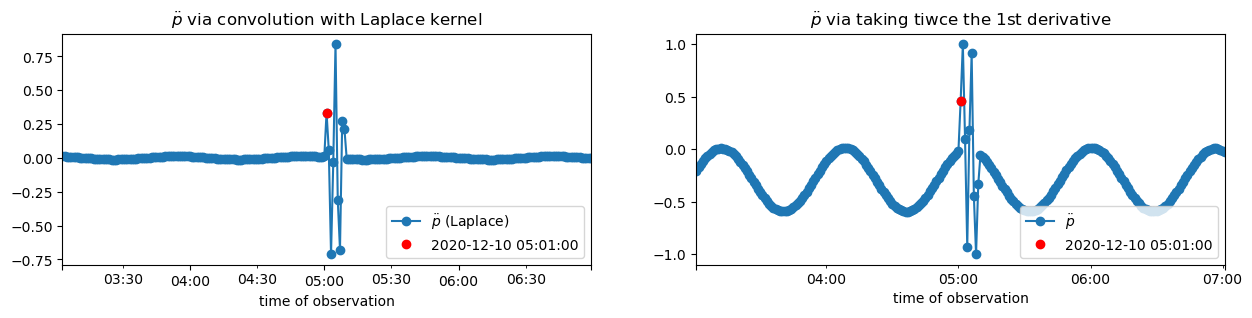

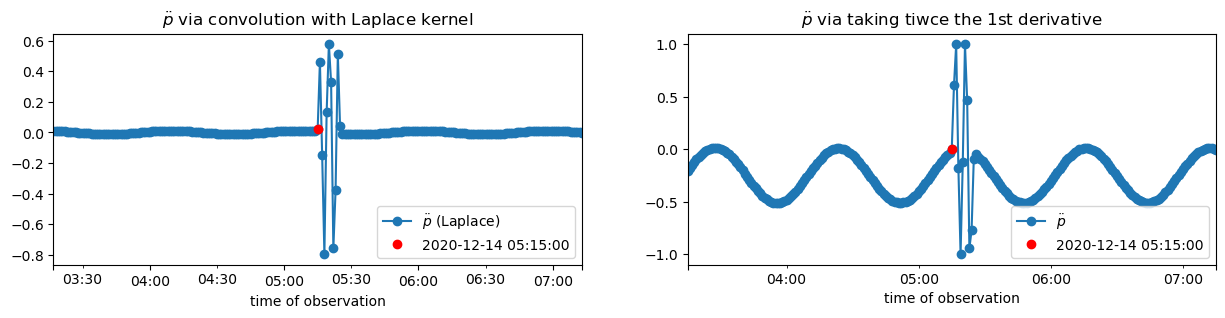

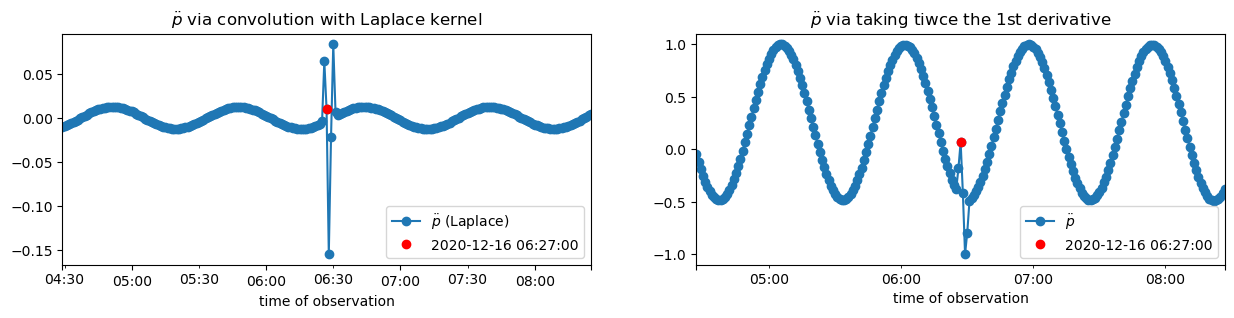

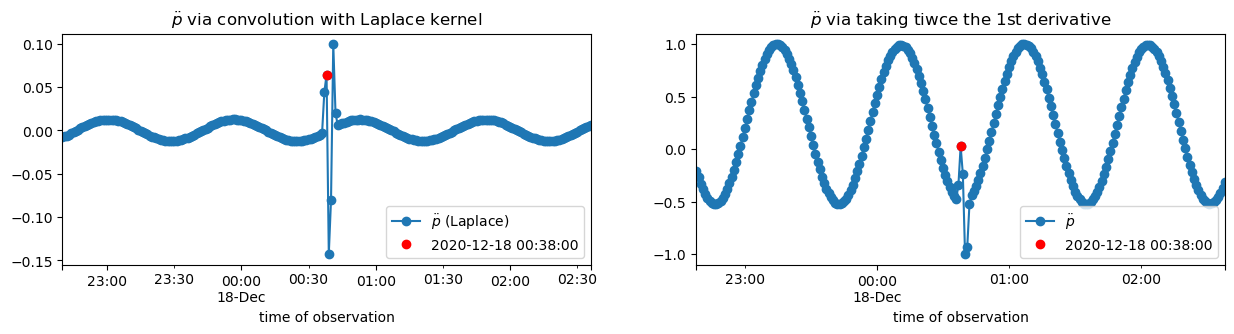

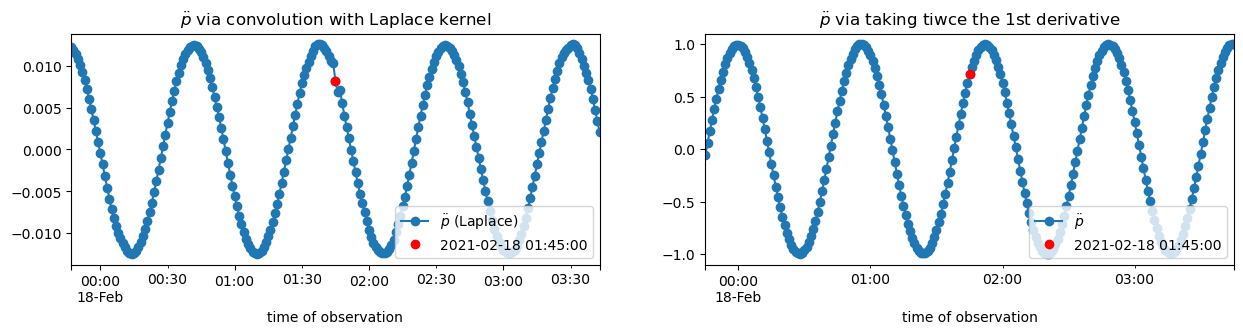

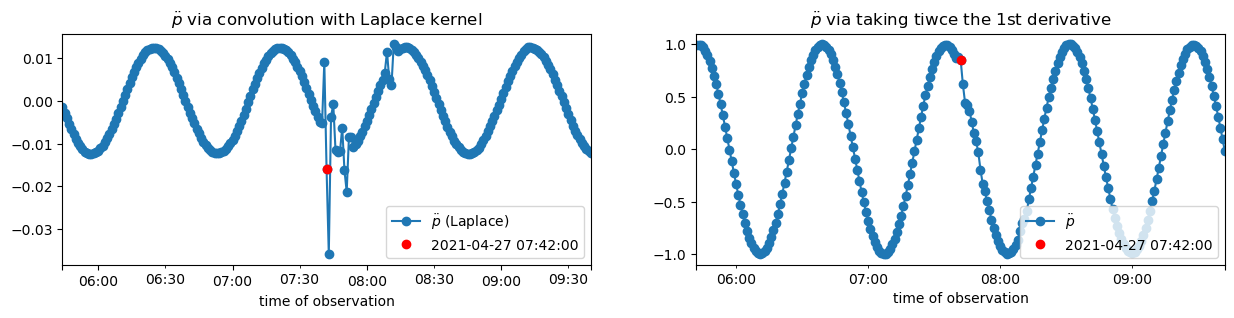

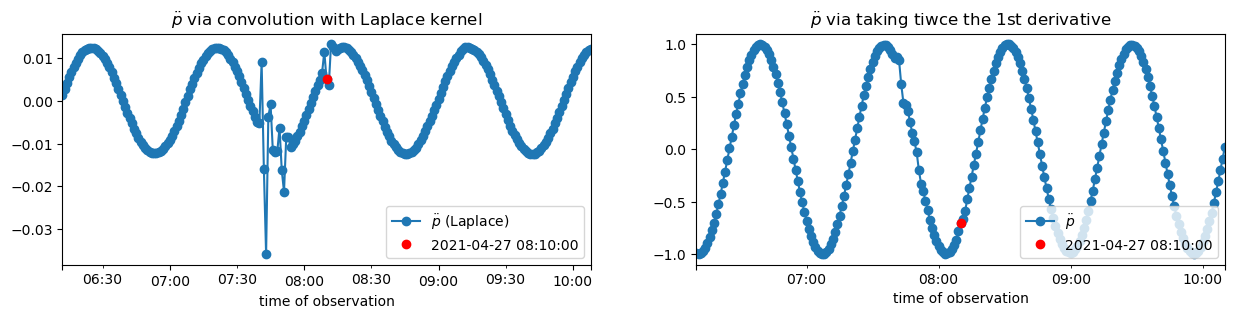

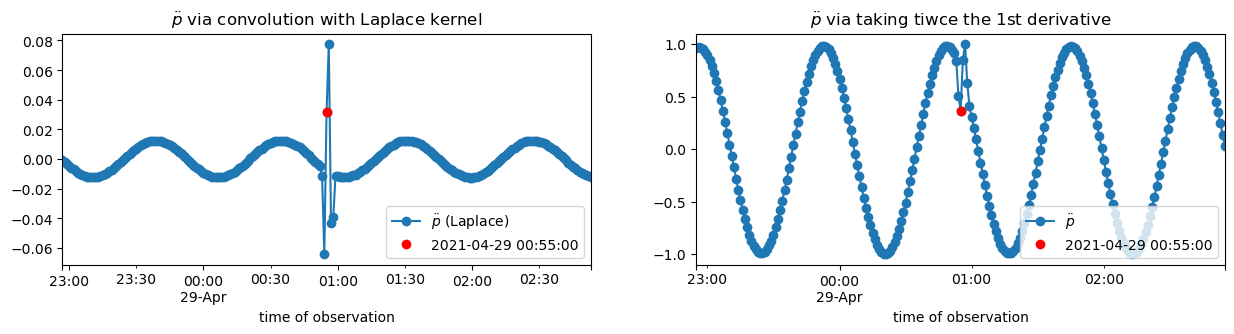

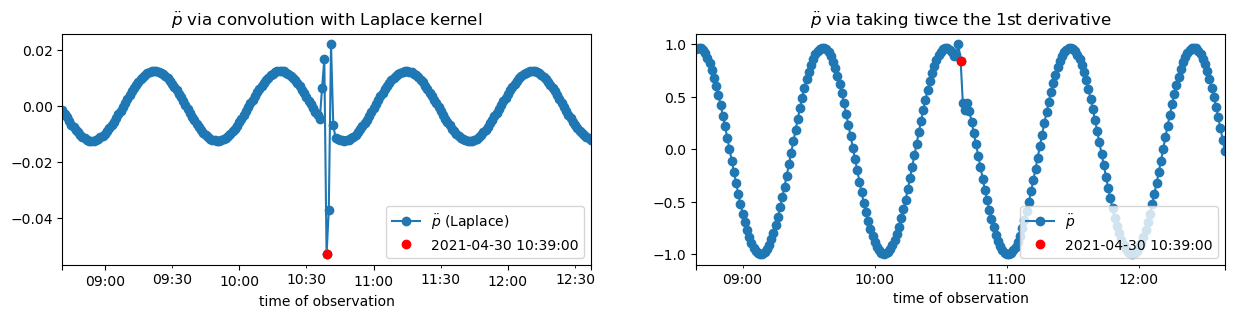

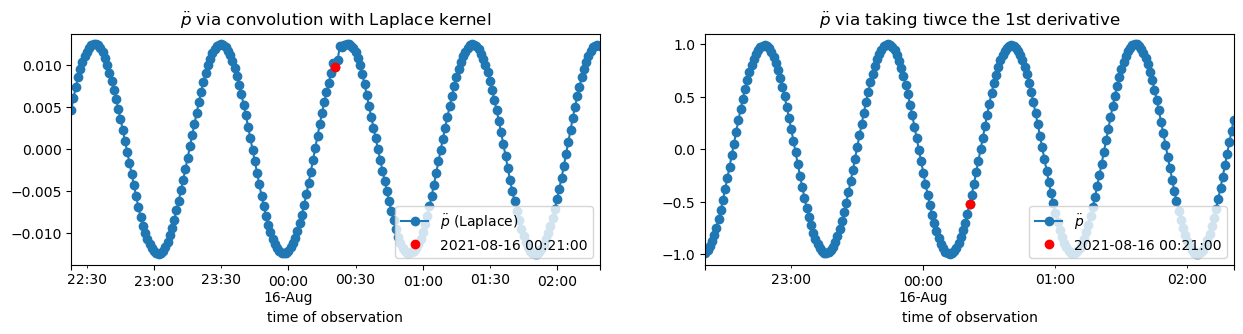

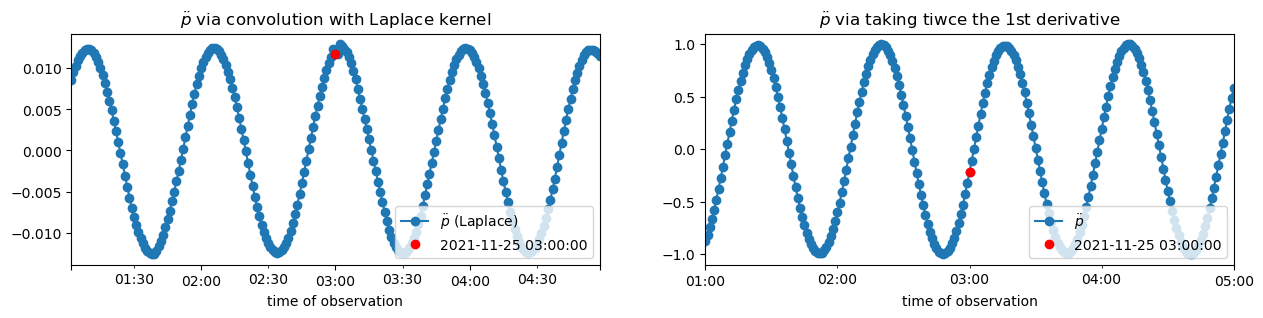

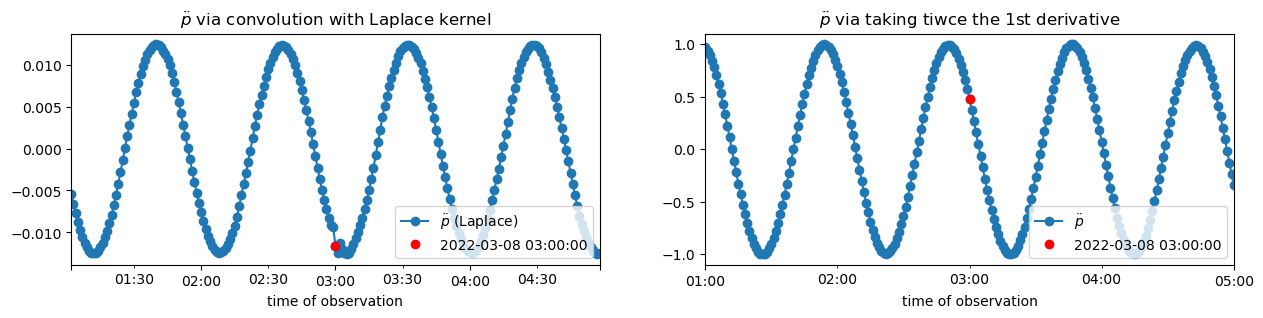

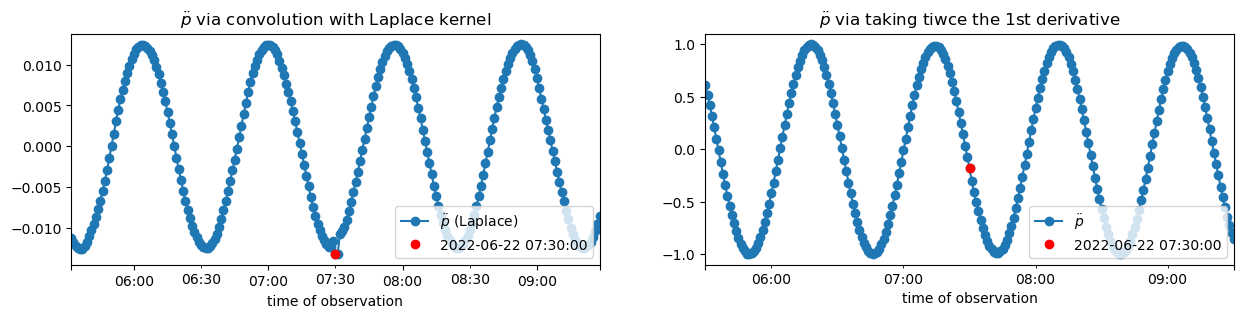

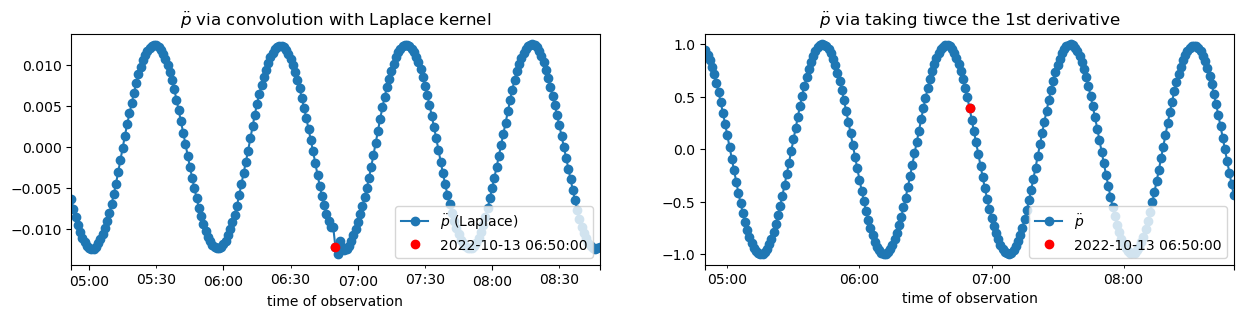

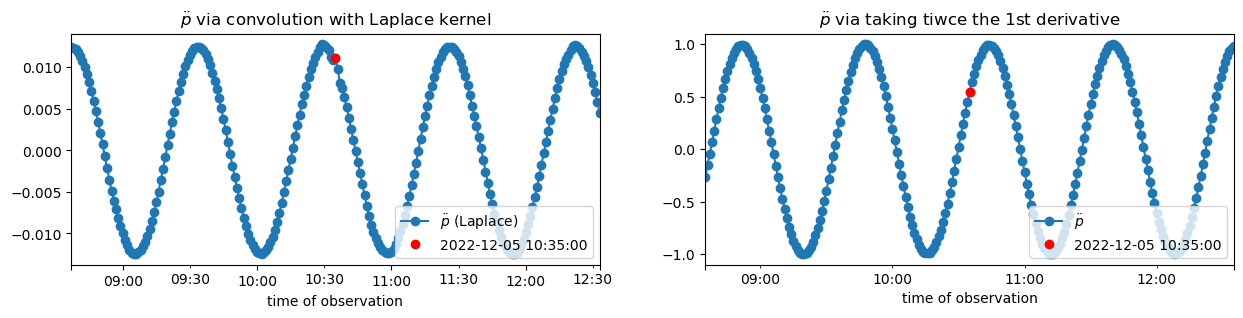

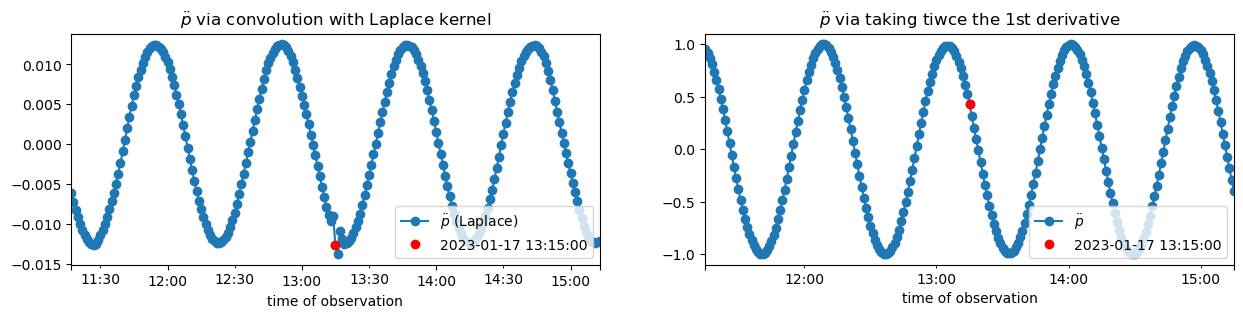

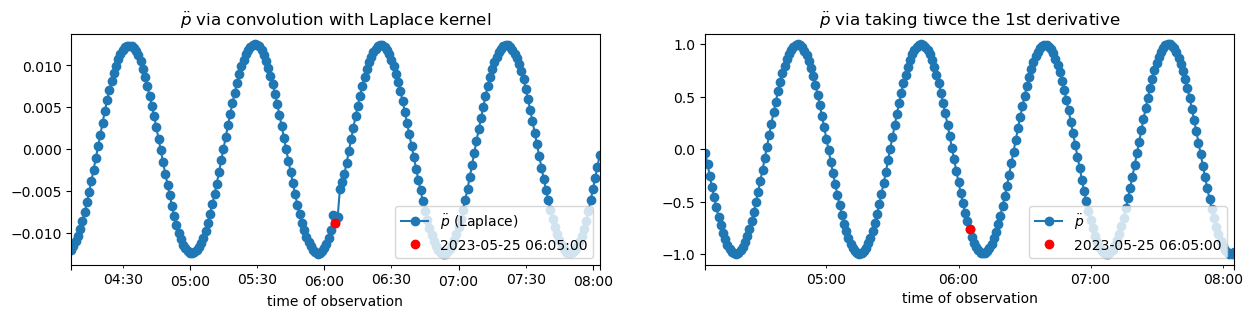

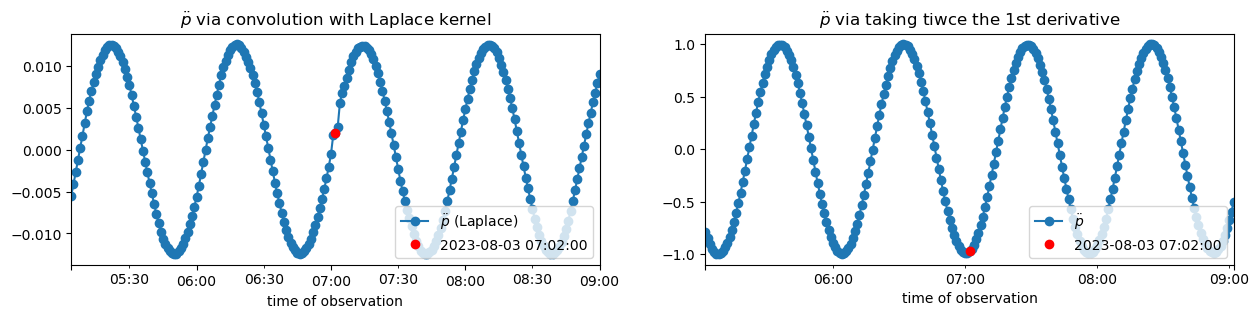

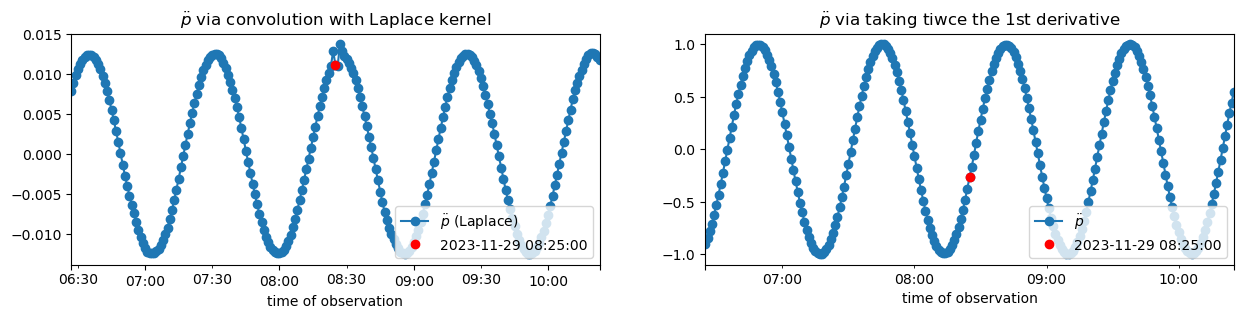

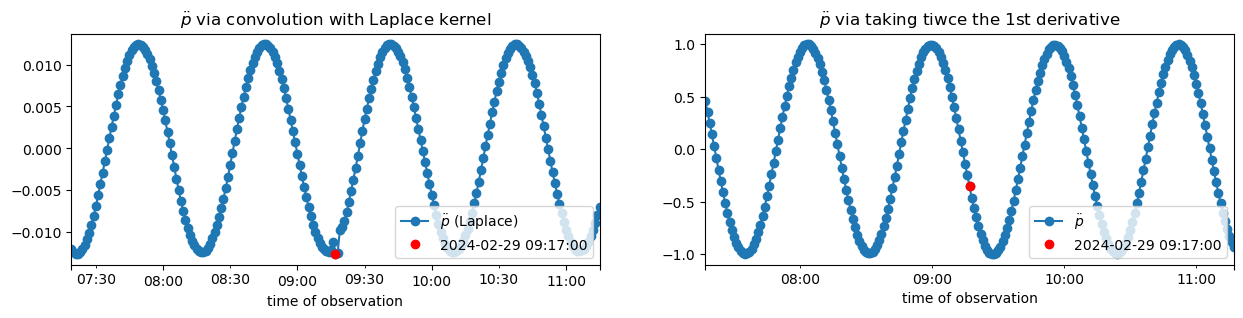

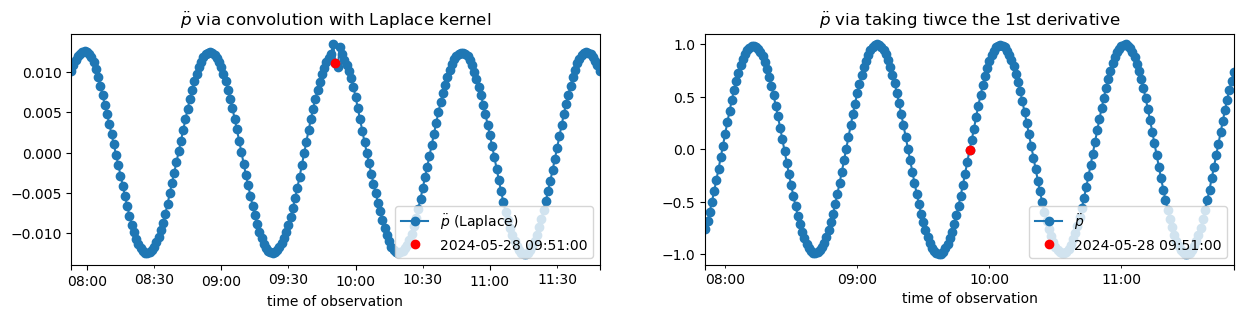

In [171]:
for date in mans6a2024.reset_index()['start'].iloc[3:]:
    man_date = str(date) #str(mans6a2024.reset_index()['start'].iloc[21])
    pdot, pdot_baseline, pdot_residuals = harmonic_reg(feature=dot_p,man_date=date)
    pddot, pddot_baseline, pddot_residuals = harmonic_reg(feature=ddot_p,man_date=date)
    # foo = gaussian_filter1d(feature_normalised,1)
    laplace = np.array([1,-2,1])
    # foo = gaussian_filter1d(foo_feature,sigma=1)
    # foo = np.convolve(laplace,foo,mode='full')[4:-4]
    pddot_laplace = pd.Series(convolve1d(pdot,laplace),index=pdot.index,name='conv_Laplace')

    # PLOT
    fig, ax = plt.subplots(ncols=2,nrows=1,figsize=(15,3))

    pddot_laplace.iloc[2:-2].plot(ax=ax[0],style='o-',label=r'$\ddot p$ (Laplace)',legend=True)
    pd.Series(pddot_laplace.loc[man_date],index=[pd.to_datetime(man_date)]).plot(ax=ax[0],style=['ro'],label = f'{man_date}',legend=True)
    ax[0].legend(loc='lower right')
    ax[0].set_title(r'$\ddot p$ via convolution with Laplace kernel')
    ax[0].set_xlabel('time of observation')

    pddot.plot(ax=ax[1],style='o-',label=r'$\ddot p$',legend=True)
    pd.Series(pddot.loc[man_date],index=[pd.to_datetime(man_date)]).plot(ax=ax[1],style=['ro'],label = f'{man_date}',legend=True)
    ax[1].legend(loc='lower right')
    ax[1].set_title(r'$\ddot p$ via taking tiwce the 1st derivative')
    ax[1].set_xlabel('time of observation')
    plt.show()


We can clearly see that computing $\ddot f$ via the convolution with the Laplace filter is more effective in detecting outliers.
This is because this method is more _local_ in the following sense. 
When computing the first derivative of the first derivative 

$$ \text{2 $\times $ first derivative:}\quad  \ddot f(x) \approx \frac{\dot f(x + h) - \dot f(x - h)}{2 h} \approx \frac{f(x + 2h) - 2f(x) + f(x - 2h)}{4 h^2} $$

and assuming for simplicity that $h$ is taken to be 1 (unit time step), we end up with  

$$ \text{2 $\times $ first derivative:}\quad \ddot f(x) \approx \frac{1}{4} \left( \vphantom{\frac12} f(x + 2) - 2f(x) + f(x - 2) \right) $$

Hence the naive computation of the second derivative effectively consideres points which come _two_ timesteps before and after the point of consideration. 
It hence "sees more points" and can therefore be considered as more _global_ as it it averages information over a wider region than the strictly local Laplace filter, which only considers _one_ timestep before and after

$$ \text{Laplace filter:}\quad \ddot f(x) = f(x + 1) - 2f(x) + f(x-1)  $$

### Strategy

In order to detect the manoeuvres, we will exploit the temporal pattern of the time series representing the feature (conserved quantity), for example the semi-parameter $p$.

The general starategy is as follows:

1. Decide on features

2. Extract a _baseline_ from the feautre by fitting several harmonics 

3. Compute residuals

4. Analyse residuals in order to detect outliers

### Feature Engineering

### Detecting Manoeuvres